## Import Necessary Packages

In [17]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## User-Defined Fields

In [2]:
CONFIGSPATH = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/src/pod/configs.json'
with open(CONFIGSPATH,'r',encoding='utf-8') as f:
    CONFIGS = json.load(f)

FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.01

## Functions

In [3]:
def get_r2(ytrue,ypred,dims=None,fillnan=None):
    if fillnan is None:
        ypred = ypred
    elif fillnan=='mean':
        ypred = ypred.fillna(float(ytrue.mean(skipna=True)))
    else:
        ypred = ypred.fillna(float(fillnan))
    if dims is None:
        dims = list(ytrue.dims)
    mu  = ytrue.mean(dim=dims,skipna=True)
    rss = ((ypred-ytrue)**2).sum(dim=dims,skipna=True)
    tss = ((ytrue-mu)**2).sum(dim=dims,skipna=True)
    r2  = 1.0- (rss/tss)
    return float(r2) if not r2.dims else r2

def get_mcc(ytrue,ypred,dims=None,nanasnone=True,prthresh=PRTHRESH):
    if dims is None:
        dims = list(ytrue.dims)
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    if nanasnone:
        ypredabove = ypredabove.fillna(False)
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True).astype('float64')
    numerator   = tp*tn-fp*fn
    denominator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mcc = xr.where(denominator==0,0.0,numerator/denominator)
    if not mcc.dims:
        return float(mcc),int(tp),int(fp),int(fn),int(tn)
    return mcc,tp.astype('int64'),fp.astype('int64'),fn.astype('int64'),tn.astype('int64')

## Load Data

In [4]:
truepath = os.path.join(FILEDIR,f'{SPLIT}.h5')
with xr.open_dataset(truepath,engine='h5netcdf') as ds:
    truepr = ds['pr'].load()

results = {}
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description',runname)
    predpath    = os.path.join(RESULTSDIR,f'pod_{runname}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['predpr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

## P-$B_L$ Relationships

In [5]:
curves = []
for run in RUNS:
    runname     = run['run_name']
    description = run.get('description',runname)
    npzpath     = os.path.join(MODELDIR,f'pod_{runname}.npz')
    with np.load(npzpath) as data:
        bincenters = data['bincenters'].astype(np.float32)
        binmeans   = data['binmeans'].astype(np.float32)
        nparams    = int(np.isfinite(binmeans).sum())
    curves.append(dict(runname=runname,description=description,bincenters=bincenters,binmeans=binmeans,nparams=nparams))

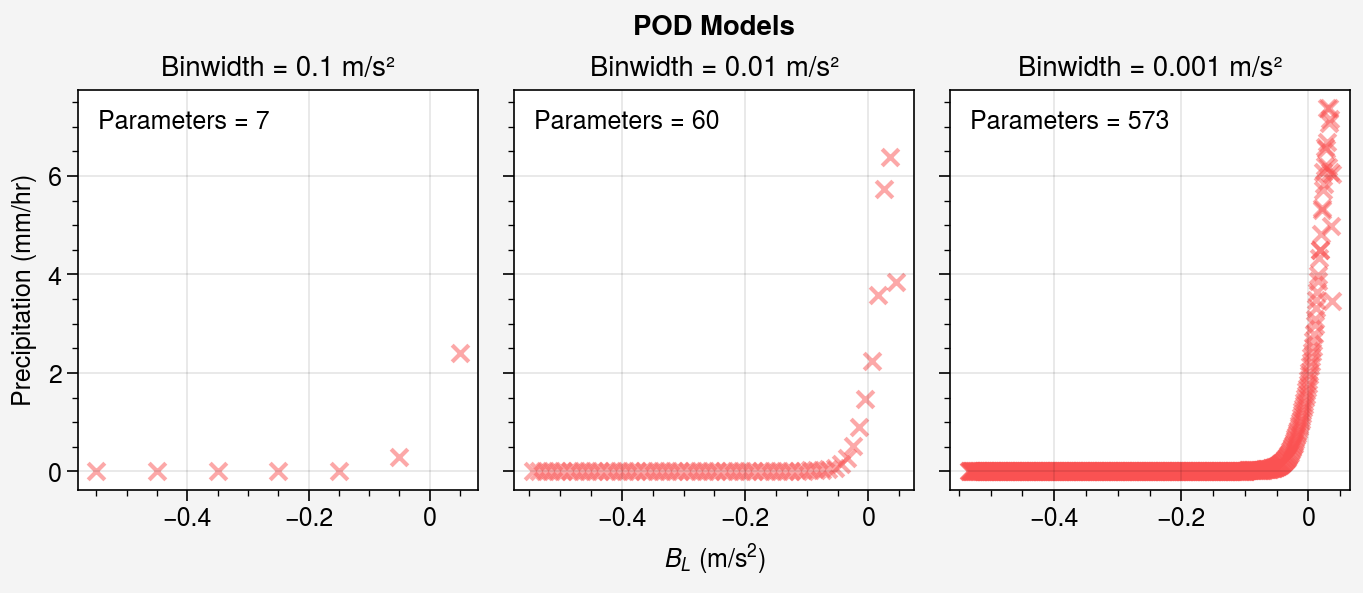

In [6]:
fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,share=True)
for i,curve in enumerate(curves):
    mask = np.isfinite(curve['binmeans'])
    axs[i].scatter(curve['bincenters'][mask],curve['binmeans'][mask],color='red6',marker='x',alpha=0.5)
    axs[i].format(title=curve['description'])
    axs[i].text(0.05,0.95,f'Parameters = {curve["nparams"]}',transform=axs[i].transAxes,va='top')
axs.format(suptitle='POD Models',xlabel='$\mathit{B_L}$ (m/s$^{2}$)',ylabel='Precipitation (mm/hr)')
pplt.show()

## 1D Distribution Comparison

In [7]:
binedges  = np.linspace(0,120,60)

paneldata = [] 
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=None,fillnan='mean')              
    mcc,*_ = get_mcc(ytrue,ypred,dims=None,nanasnone=True)
    ytrueflat = ytrue.values.ravel()
    ypredflat = ypred.values.ravel()
    paneldata.append((description,r2,mcc,ytrueflat,ypredflat))

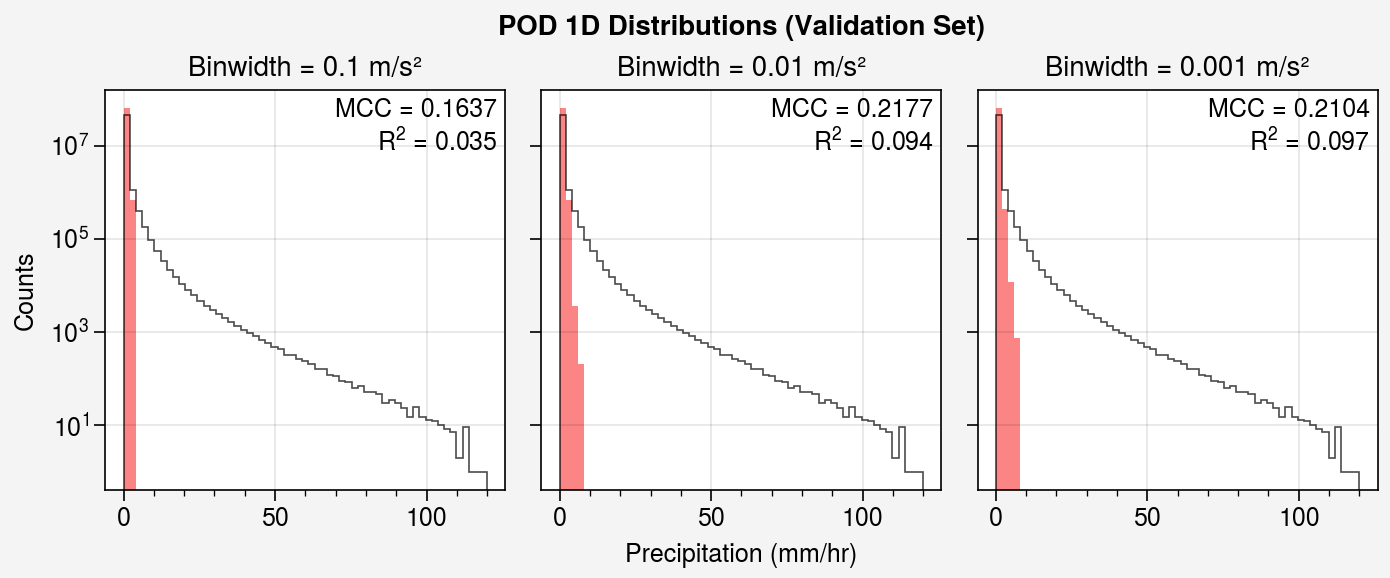

In [8]:
fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='POD 1D Distributions (Validation Set)',
           xlabel='Precipitation (mm/hr)',ylabel='Counts',yscale='log',yformatter='log')

for ax,(description,r2,mcc,ytrueflat,ypredflat) in zip(axs,paneldata):
    ax.hist(ytrueflat,bins=binedges,histtype='step',color='k',alpha=0.7)
    ax.hist(ypredflat,bins=binedges,color='red6',alpha=0.7)
    ax.text(0.98,0.98,f'MCC = {mcc:.4f}\nR$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='right')
    ax.format(title=description)
    
pplt.show()

## 2D Distribution Comparison

In [9]:
globalmin = 0
globalmax = 120
binedges  = np.linspace(globalmin,globalmax,60)

paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=None,fillnan='mean')
    mcc,*_ = get_mcc(ytrue,ypred,dims=None,nanasnone=True)
    ytrueflat = ytrue.values.ravel()
    ypredflat = ypred.values.ravel()
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
    hist = np.ma.masked_where(hist==0,hist)
    paneldata.append((description,hist,float(r2),float(mcc)))

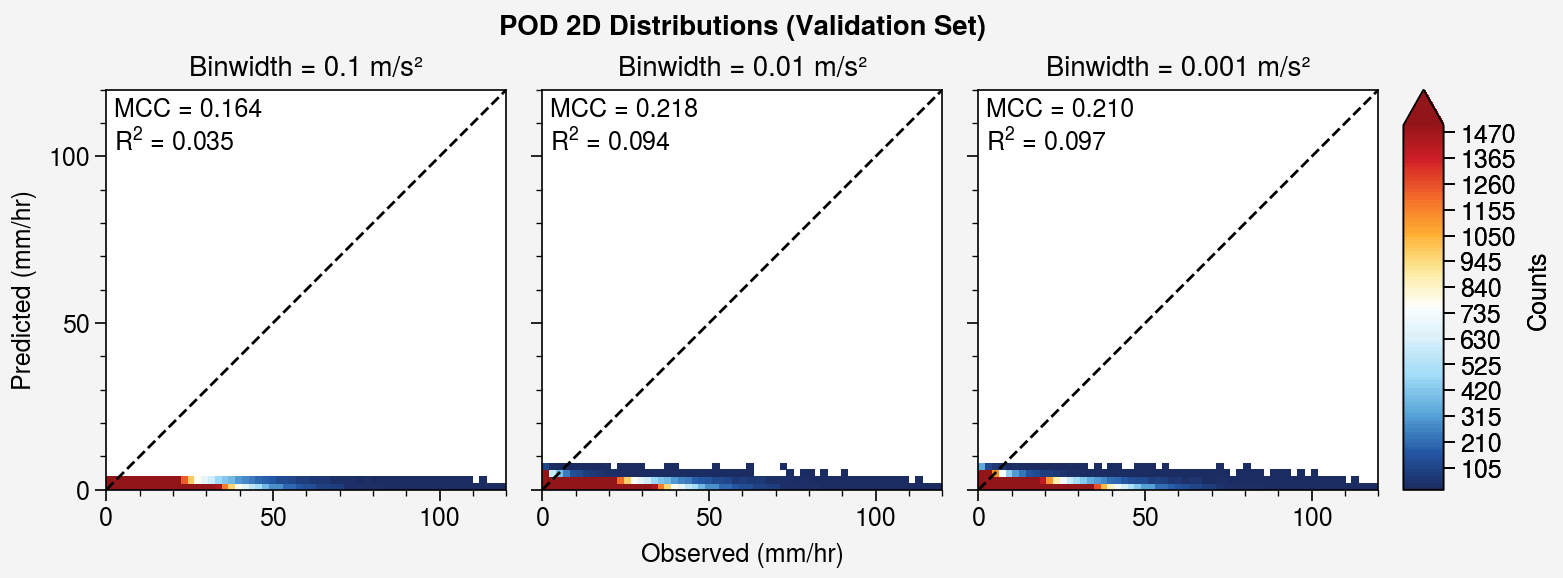

In [10]:
fig,axs = pplt.subplots(nrows=1,ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle='POD 2D Distributions (Validation Set)',xlabel='Observed (mm/hr)',ylabel='Predicted (mm/hr)')

im = None
for ax,(description,hist,r2,mcc) in zip(axs,paneldata):
    im = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
    ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
    ax.text(0.02,0.98,f'MCC = {mcc:.3f}\nR$^2$ = {r2:.3f}',transform=ax.transAxes,va='top',ha='left')
    ax.format(title=description,xlim=(globalmin,globalmax),xticks=50,ylim=(globalmin,globalmax),yticks=50)

fig.colorbar(im,loc='r',label='Counts')
pplt.show()

## Confusion Matrix

In [11]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue  = result['ytrue']
    ypred  = result['ypred']
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    mcc,tp,fp,fn,tn = get_mcc(ytrue,ypred,dims=None,nanasnone=True)
    total  = tp+fp+tn+fn
    matrix = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
    paneldata.append((description,matrix,dict(TP=tp,FP=fp,FN=fn,TN=tn,total=total)))

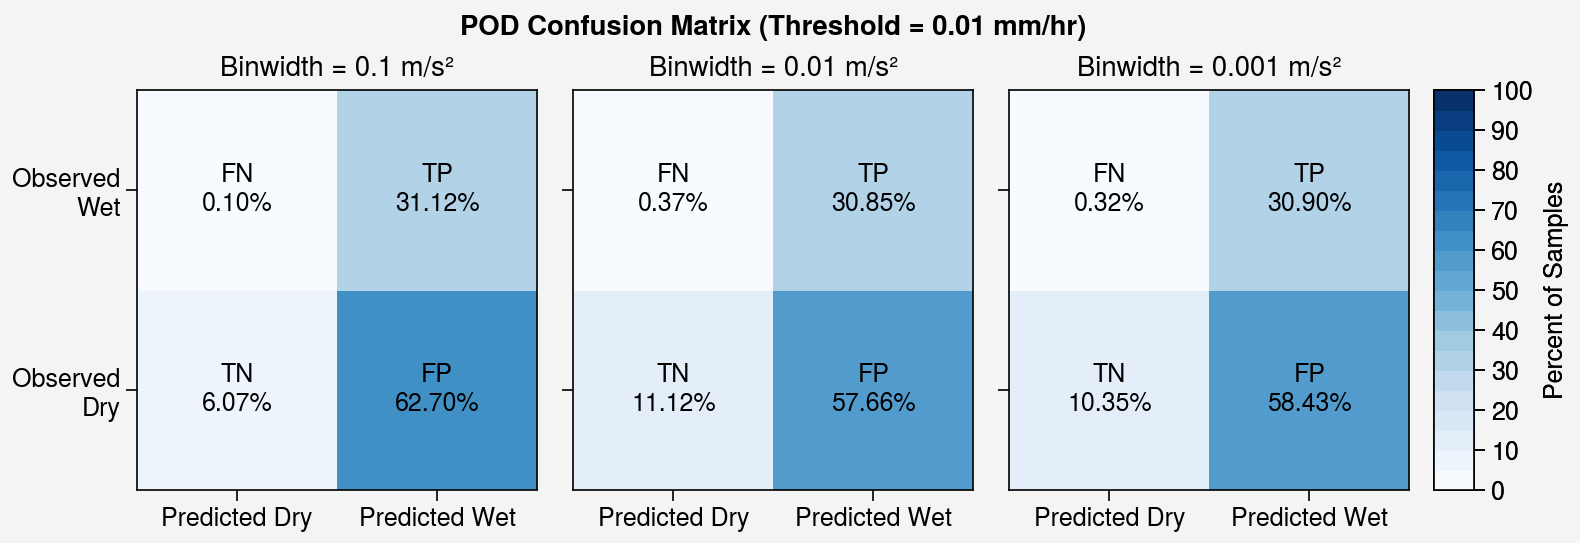

In [12]:
fig,axs = pplt.subplots(ncols=len(paneldata),refwidth=2,share=True)
axs.format(suptitle=f'POD Confusion Matrix (Threshold = {PRTHRESH} mm/hr)')

im = None
for ax,(description,matrix,count) in zip(axs,paneldata):
    xedges = [0,1,2]
    yedges = [0,1,2]
    im = ax.pcolormesh(xedges,yedges,matrix,cmap='Blues',vmin=0,vmax=100,levels=21)
    labels = [
        ('TN',count['TN'],matrix[0,0],0.5,0.5),
        ('FP',count['FP'],matrix[0,1],1.5,0.5), 
        ('FN',count['FN'],matrix[1,0],0.5,1.5), 
        ('TP',count['TP'],matrix[1,1],1.5,1.5)]
    for label,value,percent,x,y in labels:
        ax.text(x,y,f'{label}\n{percent:.2f}%',ha='center',va='center')
    ax.format(title=description,
              xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
              ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')

fig.colorbar(im,loc='r',label='Percent of Samples')
pplt.show()

## Precision-Recall Curves

We take the observed P and label each sample rainy (1) if it’s > 0.01 mm/hr, dry (0) otherwise. We then sort all observed P samples by predicted P, high to low. This basically sorts by the model’s "confidence it’s raining."

As we walk down that sorted list:
- Precision: Of the samples that the model has called rain so far, how many actually rained? This usually starts high (top of the list has the largest rain rates/"most confident" calls that it's raining), then usually drops as we include smaller rain rates/"less confident" calls.
- Recall: Of all the rainy samples in the dataset, how many have I found so far?” This starts low and rises toward 1 as we include more of the list.

Average precision (AP) is the area under the precision–recall curve. Bigger values means your model is better.
The dashed prevalence line is the overall rainy fraction you’d get by random guessing. If your precision-recall curve sits well above that line, the model is effectively learning: it packs more actually rainy samples toward the top of the ranked list, so if you pick a threshold to "flag" the top X%, you’ll catch more actual rain than chance. Below it means that you model isn't any better than random guessing.

In [13]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    ytrueflat = ytrue.values.ravel()
    ypredflat = ypred.values.ravel()
    finite = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
    ytrueabove = (ytrueflat[finite]>=PRTHRESH)
    scores     = ypredflat[finite]
    ytrueabovesorted = ytrueabove[np.argsort(scores)[::-1]]
    ytruetotal       = int(ytrueabovesorted.sum())
    tp = np.cumsum(ytrueabovesorted)
    fp = np.cumsum(1-ytrueabovesorted)
    recall    = tp/ytruetotal
    precision = tp/(tp+fp)
    recall = np.concatenate(([0.0],recall))
    precision = np.concatenate(([1.0],precision))
    precisionenv = np.maximum.accumulate(precision[::-1])[::-1]
    ap = np.sum((recall[1:]-recall[:-1])*precisionenv[1:])
    prevalence = ytruetotal/ytrueabovesorted.size
    paneldata.append((description,recall,precision,float(ap),float(prevalence)))

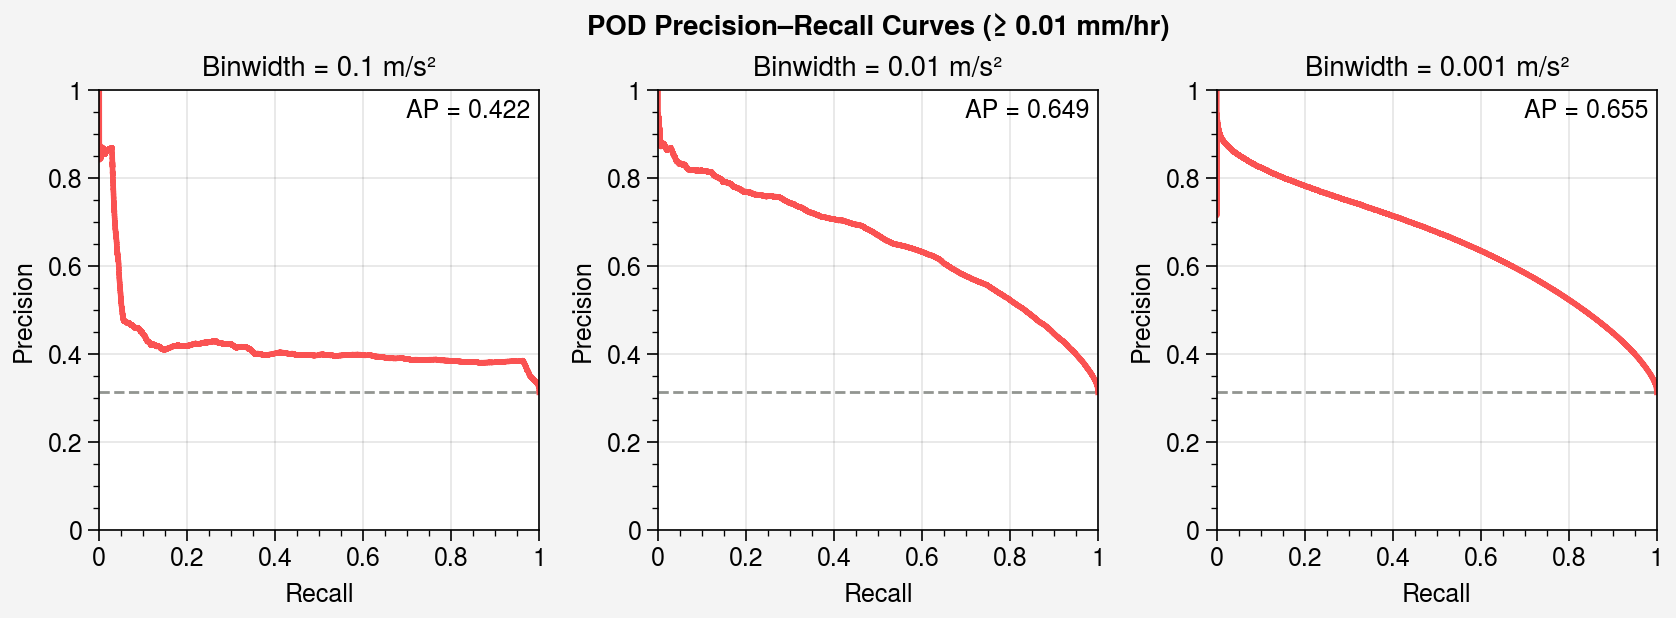

In [14]:
fig,axs = pplt.subplots(ncols=len(paneldata),refwidth=2.2,share=False)
axs.format(suptitle=f'POD Precision–Recall Curves (≥ {PRTHRESH} mm/hr)',
           xlabel='Recall',xlim=(0,1),ylabel='Precision',ylim=(0,1))
for ax,(description,recall,precision,ap,prevalence) in zip(axs,paneldata):
    ax.plot(recall,precision,color='red6',linewidth=2)
    ax.hlines(prevalence,0,1,color='gray',linewidth=1,linestyle='--')
    ax.text(0.98,0.98,f'AP = {ap:.3f}',transform=ax.transAxes,ha='right',va='top')
    ax.format(title=description)
pplt.show()

## $\mathrm{R^2}$ and MCC Maps

Across all binwidths, $\mathrm{R^2}$ values are low (< 0.3), as expected. More complex POD models reveal more spatial variability in $\mathrm{R^2}$, but not necessarilty stronger correlation. MCC values are higher and more coherent than $\mathrm{R^2}$, sugesting this metric better captrues the classification skill more robustly. Skill almost always positive, showing that the model has skill in classifying rain versus no rain.

In [15]:
paneldata = []
for runname,result in results.items():
    description = result['description']
    ytrue = result['ytrue']
    ypred = result['ypred']
    r2     = get_r2(ytrue,ypred,dims=['time'],fillnan=None)
    mcc,*_ = get_mcc(ytrue,ypred,dims=['time'],nanasnone=True)
    paneldata.append((description,r2,mcc))

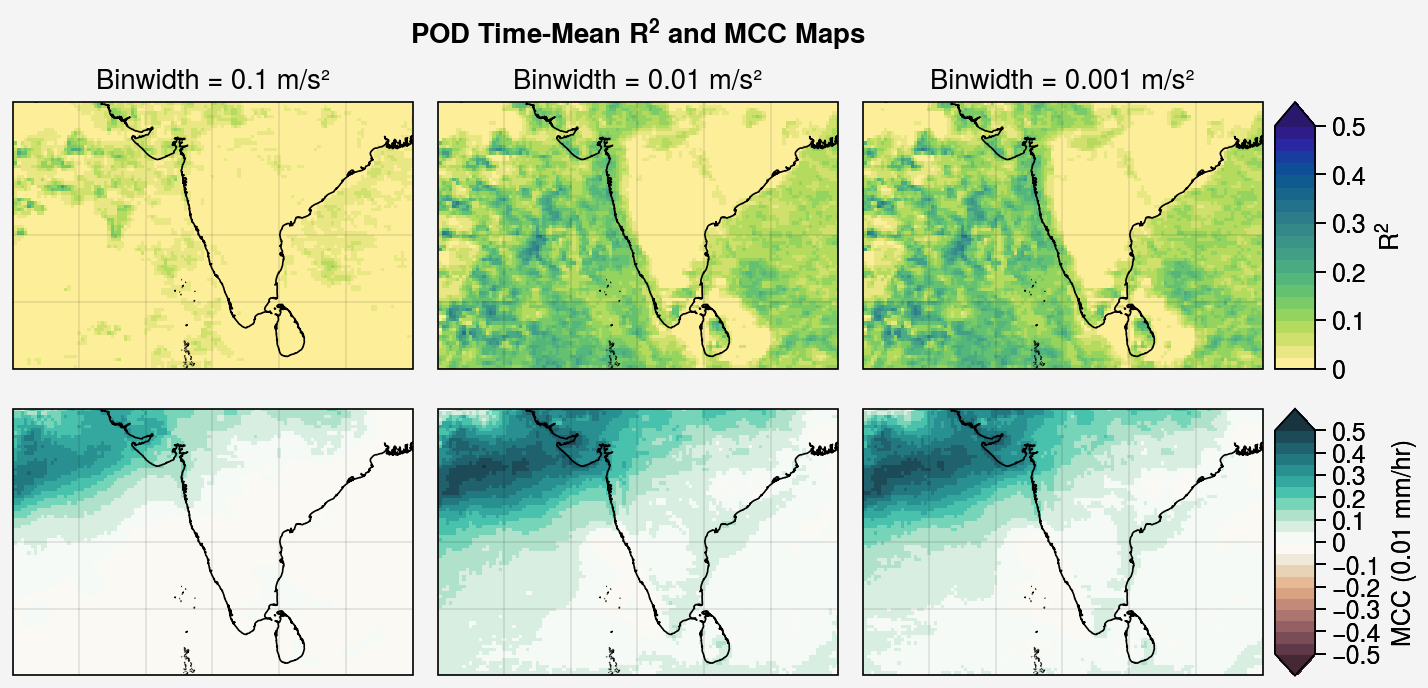

In [16]:
fig,axs = pplt.subplots(nrows=2,ncols=len(paneldata),refwidth=2,proj='cyl',share=False)
axs.format(suptitle=f'POD Time-Mean R$^2$ and MCC Maps',
           coast=True,latlim=(5.,25.),latlines=[5,10,15],lonlim=(60.,90.),lonlines=5)

im1,im2 = None,None
for col,(description,r2,mcc) in enumerate(paneldata):
    im1 = axs[0,col].pcolormesh(r2.lon,r2.lat,r2,cmap='Haline_r',vmin=0,vmax=0.5,levels=20,extend='max')
    im2 = axs[1,col].pcolormesh(mcc.lon,mcc.lat,mcc,cmap='DryWet',vmin=-0.5,vmax=0.5,levels=20,extend='both')
    axs[0,col].format(title=description)
axs[2].colorbar(im1,loc='r',label='R$^2$',ticks=0.1)
axs[-1].colorbar(im2,loc='r',label=f'MCC ({PRTHRESH} mm/hr)',ticks=0.1)
pplt.show()